In [1]:
import pandas
import datetime
import urllib
import bs4
import numpy
from davitpy.models import *
from davitpy import utils
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
import seaborn as sns
%matplotlib inline

In [2]:
# get dst index vals from wdc kyoto website
# create a list of dates with monthly freq
date_dst_arr = []
dst_val = []
dst_time_del = datetime.timedelta(hours = 1)
start_date = datetime.datetime(2011,1,1)
end_date = datetime.datetime(2014,12,31)
daterange = pandas.date_range(start_date, end_date, freq="M")
for dt in daterange:
    if dt.month <= 9:
            monthStr = "0" + str(dt.month)
    else:
        monthStr = str(dt.month)
    if dt.year >= 2015:
        # create the url
        currUrl = "http://wdc.kugi.kyoto-u.ac.jp/" + "dst_realtime" + \
            "/" + str(dt.year) + monthStr + "/index.html"
    elif ( (dt.year > 2011) and (dt.year < 2015) ):
        # create the url
        currUrl = "http://wdc.kugi.kyoto-u.ac.jp/" + "dst_provisional" + \
            "/" + str(dt.year) + monthStr + "/index.html"
    else:
        # create the url
        currUrl = "http://wdc.kugi.kyoto-u.ac.jp/" + "dst_final" + \
            "/" + str(dt.year) + monthStr + "/index.html"
    conn = urllib.urlopen(currUrl)
    htmlSource = conn.read()
    soup = bs4.BeautifulSoup(htmlSource, 'html.parser')
    dataResObj = soup.find("pre", { "class" : "data" })
    # get the data as a list of strings after removing white space
    lines = dataResObj.text.strip().splitlines()
    for line in lines[6:]:
        columns = line.split()
        if len( columns ) > 0. :
            date_dst_arr.append( datetime.datetime( \
                dt.year, dt.month, int(columns[0]), 1 ) )
            for cols in range( len( columns[1:] ) ) :
                try:
                    inNumberFloatTest = float(columns[cols + 1])
                except:
                    # split these cols as well and work on them!
                    try:
                        missedCols = columns[cols + 1].split("-")[1:]
                        if len(missedCols) >= 1:
                            for mcols in missedCols:
                                dst_val.append( -1*float( mcols ) )
                                # now since we added the date earlier we need to be
                                # careful about appending date values
                                if ( len(date_dst_arr) != len(dst_val) ):
                                    date_dst_arr.append ( date_dst_arr[-1] + dst_time_del )
                    except:
                        print "something wrong with messed up vals!-->", columns[cols + 1]
                        continue
                    continue
                # I have to do this because of the messed up way Kyoto puts up the latest dst value..
                # mixed with 9999 (fillers) like if latest dst is 1 then Kyoto puts it as 199999.....
                if len( columns[ cols + 1 ] ) < 5 :
                    dst_val.append( float( columns[ cols + 1 ] ) )
                elif ( len( columns[ cols + 1 ] ) > 5 and columns[ cols + 1 ][0:3] != '999' ) :
                    mixed_messed_dst = ''
                    for jj in range(5) :
                        if columns[ cols + 1 ][jj] != '9' :
                            mixed_messed_dst = mixed_messed_dst + columns[ cols + 1 ][jj]

                    if mixed_messed_dst != '-' :
                        dst_val.append( float( mixed_messed_dst ) )
                    else :
                        dst_val.append( float( 'nan' ) )
                else :
                    dst_val.append( float( 'nan' ) )
                if cols > 0 :
                    date_dst_arr.append ( date_dst_arr[-1] + dst_time_del )
# convert dst data to a dataframe
dstDF = pandas.DataFrame(
    {'dst_date': date_dst_arr,
     'dst_index': dst_val
    })
dstDF["dateStr"] = dstDF["dst_date"].map(lambda x: x.strftime('%Y%m%d'))
dstDF["hour"] = dstDF["dst_date"].map(lambda x: x.strftime('%H'))
dstDF.head()

dst_date  dst_index   dateStr hour
0 2011-01-01 01:00:00      -11.0  20110101   01
1 2011-01-01 02:00:00      -11.0  20110101   02
2 2011-01-01 03:00:00       -9.0  20110101   03
3 2011-01-01 04:00:00       -5.0  20110101   04
4 2011-01-01 05:00:00       -3.0  20110101   05

In [20]:
fltdTrghLocFname = "../data/trghLocFltrd.txt"
fltTecDataDF = pandas.read_csv(fltdTrghLocFname, sep=' ',\
                            parse_dates=["date"],\
                               infer_datetime_format=True)
# add the dateStr and hour columns to join with Dst DF
fltTecDataDF["dateStr"] = fltTecDataDF["date"].map(lambda x: x.strftime('%Y%m%d'))
fltTecDataDF["hour"] = fltTecDataDF["date"].map(lambda x: x.strftime('%H'))
# Merge with Dst DF 
fltTecDataDF = pandas.merge( fltTecDataDF, dstDF, on=["dateStr", "hour"] )
# add dst_bins
dstBins = [ -150, -75, -50, -25, -10, 10 ]
fltTecDataDF = pandas.concat( [ fltTecDataDF, \
                    pandas.cut( fltTecDataDF["dst_index"], \
                               bins=dstBins ) ], axis=1 )
# rename dst_bin col and discard a couple of useless cols 
fltTecDataDF.columns = [ 'BndEquGlat', 'BndEquMlat', 'BndEquMlon', 'BndEquTecVal',
                       'BndGlon', 'BndPolGlat', 'BndPolMlat', 'BndPolMlon',
                       'BndPolTecVal', 'date', 'minFltrdTecVal', 'minTecGlat',
                       'minTecMlat', 'minTecMlon', 'minTecVal', 'dateStr', 'hour',
                       'dst_date', 'dst_index', 'dst_bin' ]
fltTecDataDF = fltTecDataDF[ [ 'BndEquGlat', 'BndEquMlat', 'BndEquMlon', 'BndEquTecVal',
                       'BndGlon', 'BndPolGlat', 'BndPolMlat', 'BndPolMlon',
                       'BndPolTecVal', 'date', 'minFltrdTecVal', 'minTecGlat',
                       'minTecMlat', 'minTecMlon', 'minTecVal', 'dateStr', 'hour',
                       'dst_date', 'dst_index', 'dst_bin' ] ]

fltTecDataDF.head()

BndEquGlat  BndEquMlat  BndEquMlon  BndEquTecVal  BndGlon  BndPolGlat  \
0        38.0   47.634053  -37.976848           4.3   -105.0        44.0   
1        38.0   47.794316  -36.738952           4.2   -104.0        44.0   
2        38.0   47.950059  -35.489789           4.5   -103.0        44.0   
3        43.0   54.150050  -15.556051           6.5    -88.0        50.0   
4        44.0   54.911023   -4.149966           5.4    -80.0        51.0   

   BndPolMlat  BndPolMlon  BndPolTecVal                date  minFltrdTecVal  \
0   53.490621  -38.841781          5.35 2011-02-05 02:32:30        3.881276   
1   53.643162  -37.552536          5.10 2011-02-05 02:32:30        3.730546   
2   53.790550  -36.251329          4.70 2011-02-05 02:32:30        3.939476   
3   60.836759  -15.643711          5.00 2011-02-05 02:32:30        4.273354   
4   61.598575   -3.788082          4.20 2011-02-05 02:32:30        3.571592   

   minTecGlat  minTecMlat  minTecMlon  minTecVal   dateStr hour  \
0        40.0   49.582218  -38.251632        3.4  20110205   02   
1        40.0   49.739906  -36.996803        3.4  20110205   02   
2        41.0   50.866049  -35.855276        3.7  20110205   02   
3        47.0   57.972376  -15.584212        3.9  20110205   02   
4        49.0   59.688923   -3.884564        1.9  20110205   02   

             dst_date  dst_index     dst_bin  
0 2011-02-05 02:00:00      -50.0  (-75, -50]  
1 2011-02-05 02:00:00      -50.0  (-75, -50]  
2 2011-02-05 02:00:00      -50.0  (-75, -50]  
3 2011-02-05 02:00:00      -50.0  (-75, -50]  
4 2011-02-05 02:00:00      -50.0  (-75, -50]

In [26]:
trghMeanDF = fltTecDataDF.groupby( [ "BndGlon", "dst_bin" ] ).mean().reset_index()
trghMeanDF.dropna(inplace=True)
trghMeanDF.head()
# get a count of how many values are present in each dst group
cntGrps = fltTecDataDF[ ["dateStr", "dst_bin"] ].groupby( [ "dst_bin" ] ).aggregate(lambda x: len(set(list(x)))).reset_index()
# cntGrps["len"] = [ set(x) for x in cntGrps["dateStr"] ]
print cntGrps

       dst_bin  dateStr
0  (-150, -75]        0
1   (-75, -50]        3
2   (-50, -25]        8
3   (-25, -10]        1
4    (-10, 10]        0


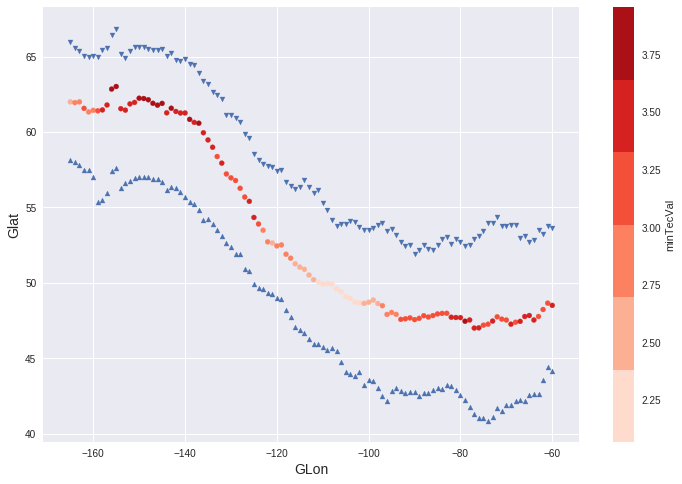

In [5]:
# Make a comparison plot of the data
# for prob of occ at diff locs
# Set up the matplotlib figure
f = plt.figure(figsize=(12, 8))
ax1 = f.add_subplot(1,1,1)

seaMap = ListedColormap(sns.color_palette("Reds"))

trghMeanSel = trghMeanDF[ trghMeanDF["dst_bin"] == "(-50, -25]" ]
trghMeanSel.plot( kind='scatter',
              x='BndGlon',
              y='minTecGlat',
              c='minTecVal',
              s=25, cmap=seaMap, ax=ax1)
trghMeanSel.plot( kind='scatter',
              x='BndGlon',
              y='BndEquGlat',
              s=25, marker='^', ax=ax1)
trghMeanSel.plot( kind='scatter',
              x='BndGlon',
              y='BndPolGlat',
              s=25, marker='v', ax=ax1)
ax1.set_xlabel("GLon", fontsize=14)
ax1.set_ylabel("Glat", fontsize=14)

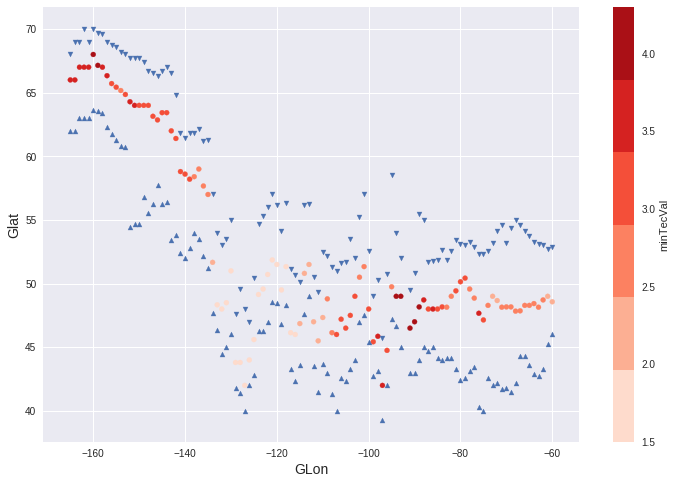

In [6]:
# Make a comparison plot of the data
# for prob of occ at diff locs
# Set up the matplotlib figure
f = plt.figure(figsize=(12, 8))
ax1 = f.add_subplot(1,1,1)

seaMap = ListedColormap(sns.color_palette("Reds"))

trghMeanSel = trghMeanDF[ trghMeanDF["dst_bin"] == "(-25, -10]" ]
trghMeanSel.plot( kind='scatter',
              x='BndGlon',
              y='minTecGlat',
              c='minTecVal',
              s=25, cmap=seaMap, ax=ax1)
trghMeanSel.plot( kind='scatter',
              x='BndGlon',
              y='BndEquGlat',
              s=25, marker='^', ax=ax1)
trghMeanSel.plot( kind='scatter',
              x='BndGlon',
              y='BndPolGlat',
              s=25, marker='v', ax=ax1)
ax1.set_xlabel("GLon", fontsize=14)
ax1.set_ylabel("Glat", fontsize=14)